In [2]:
import yfinance as yf
import datetime as dt
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

In [3]:
sp500_data = yf.download("^GSPC", start="2017-01-01", end="2022-10-16")
sp500_df = pd.DataFrame(sp500_data)
sp500_df.to_csv("sp500_data.csv")

[*********************100%***********************]  1 of 1 completed


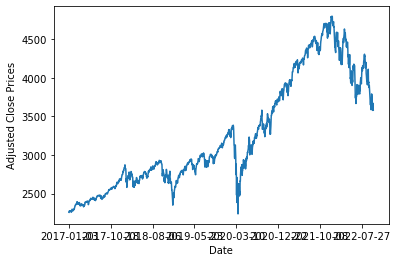

In [4]:
read_df = pd.read_csv("sp500_data.csv")
read_df.set_index("Date", inplace=True)
read_df['Adj Close'].plot()
plt.ylabel("Adjusted Close Prices")
plt.show()

In [5]:
df = pd.read_csv("sp500_data.csv")
df.set_index("Date", inplace=True)
df.dropna(inplace=True)

In [6]:
x = df.iloc[:, 0:5].values
y = df.iloc[:, 4].values

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.26,  random_state=0)

In [8]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [9]:
model = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
model.fit(x_train, y_train)
predict = model.predict(x_test)
print(predict)
print(predict.shape)

[2863.87693317 2578.58103162 2730.54911983 2712.99803287 2428.73841373
 3875.47421851 3561.50092383 2630.64953995 2743.70382029 4519.07353585
 3012.67220988 4401.33761905 2887.40756522 2349.47860564 4223.09386669
 4079.81973633 2656.59740768 2432.89410287 2603.0387248  2870.75261313
 2363.10152285 3237.19680767 3766.50819466 2374.49268674 2582.31583509
 3200.15664925 2998.24440086 4163.15746241 3932.05396236 3914.22202198
 2767.85109087 4370.63924124 4357.31464113 2497.17043646 2846.05166387
 4259.1077269  3966.68172135 4484.67617471 3900.37361525 4422.62395881
 2349.62613718 2656.14077532 3283.06417245 3669.32637386 2784.00916555
 4575.67870801 2890.85415382 2840.12262445 3114.31278756 4019.53506494
 3131.96801812 2659.13209143 3798.6425083  2803.2096222  2633.25412021
 2862.90993559 2272.33714913 2501.06121401 3516.31386865 2475.56233113
 3527.02781836 2497.82963549 2873.19789629 4586.35164063 2270.40156101
 3668.06889644 3973.22791868 3908.80335421 3075.85920535 2869.78375426
 4445.

In [10]:
grid_rf = {
'n_estimators': [20, 50, 100, 500, 1000],  
'max_depth': np.arange(1, 15, 1),  
'min_samples_split': [2, 10, 9], 
'min_samples_leaf': np.arange(1, 15, 2, dtype=int),  
'bootstrap': [True, False], 
'random_state': [1, 2, 30, 42]
}
rscv = RandomizedSearchCV(estimator=model, param_distributions=grid_rf, cv=3, n_jobs=-1, verbose=2, n_iter=200)
rscv_fit = rscv.fit(x_train, y_train)
best_parameters = rscv_fit.best_params_
print(best_parameters)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'random_state': 42, 'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 12, 'bootstrap': False}


In [11]:
print("Mean Absolute Error:", round(metrics.mean_absolute_error(y_test, predict), 4))
print("Mean Squared Error:", round(metrics.mean_squared_error(y_test, predict), 4))
print("Root Mean Squared Error:", round(np.sqrt(metrics.mean_squared_error(y_test, predict)), 4))
print("(R^2) Score:", round(metrics.r2_score(y_test, predict), 4))
print(f'Train Score : {model.score(x_train, y_train) * 100:.2f}% and Test Score : {model.score(x_test, y_test) * 100:.2f}% using Random Tree Regressor.')
errors = abs(predict - y_test)
mape = 100 * (errors / y_test)
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.') 

Mean Absolute Error: 1.927
Mean Squared Error: 12.3178
Root Mean Squared Error: 3.5097
(R^2) Score: 1.0
Train Score : 100.00% and Test Score : 100.00% using Random Tree Regressor.
Accuracy: 99.94 %.


In [12]:
predictions = pd.DataFrame({"Predictions": predict}, index=pd.date_range(start=df.index[-1], periods=len(predict), freq="D"))
predictions.to_csv("Predicted-price-data.csv")
#colllects future days from predicted values
oneyear_df = pd.DataFrame(predictions[:252])
oneyear_df.to_csv("one-year-predictions.csv")
onemonth_df = pd.DataFrame(predictions[:21])
onemonth_df.to_csv("one-month-predictions.csv")
fivedays_df = pd.DataFrame(predictions[:5])
fivedays_df.to_csv("five-days-predictions.csv")

Buy price and date
            Predictions
Date                   
12/17/2022  2270.401561
Sell price and date
           Predictions
Date                  
4/23/2023  4769.873936


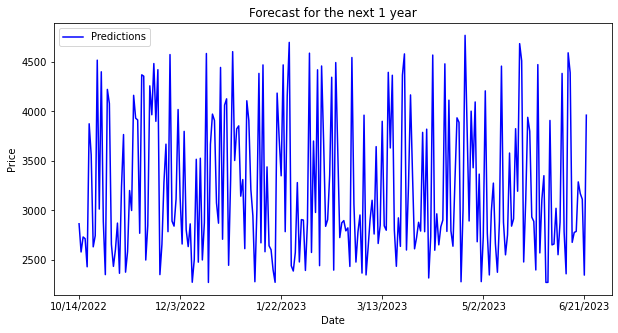

In [17]:
oneyear_df_pred = pd.read_csv("one-year-predictions.csv")
oneyear_df_pred.set_index("Date", inplace=True)
buy_price = min(oneyear_df_pred["Predictions"])
sell_price = max(oneyear_df_pred["Predictions"])
oneyear_buy = oneyear_df_pred.loc[oneyear_df_pred["Predictions"] == buy_price]
oneyear_sell = oneyear_df_pred.loc[oneyear_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(oneyear_buy)
print("Sell price and date")
print(oneyear_sell)
oneyear_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the next 1 year", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [23]:
sp500_data_test1y = yf.download("^GSPC", start="2022-10-14", end="2023-03-26")
sp500_df_testy = pd.DataFrame(sp500_data_test1y)
sp500_df_testy.to_csv("sp500_data_test1y.csv")

[*********************100%***********************]  1 of 1 completed


Buy price and date
                 Values
Date                   
10/14/2022  3583.070068
Sell price and date
               Values
Date                 
2/2/2023  4179.759766


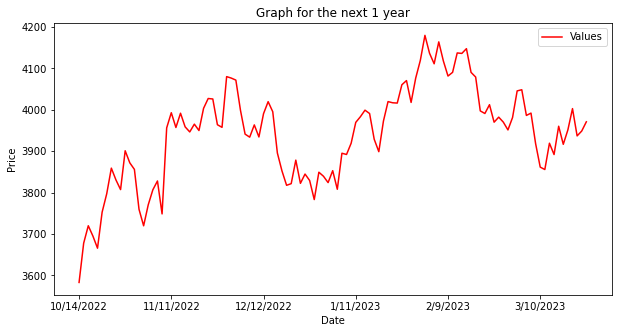

In [25]:
oneyear_df_pred = pd.read_csv("sp500_data_test1y.csv")
oneyear_df_pred.set_index("Date", inplace=True)
buy_price = min(oneyear_df_pred["Values"])
sell_price = max(oneyear_df_pred["Values"])
oneyear_buy = oneyear_df_pred.loc[oneyear_df_pred["Values"] == buy_price]
oneyear_sell = oneyear_df_pred.loc[oneyear_df_pred["Values"] == sell_price]
print("Buy price and date")
print(oneyear_buy)
print("Sell price and date")
print(oneyear_sell)
oneyear_df_pred["Values"].plot(figsize=(10, 5), title="Graph for the next 1 year", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Buy price and date
            Predictions
Date                   
10/27/2022  2349.478606
Sell price and date
            Predictions
Date                   
10/23/2022  4519.073536


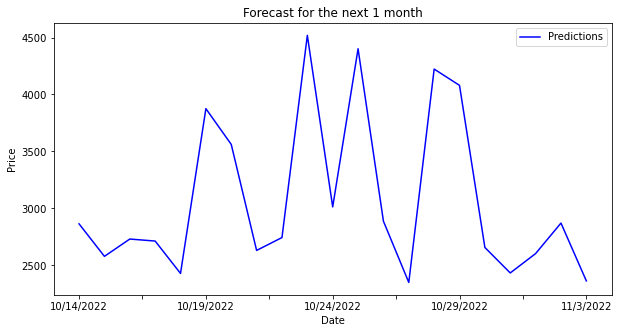

In [18]:
onemonth_df_pred = pd.read_csv("one-month-predictions.csv")
onemonth_df_pred.set_index("Date", inplace=True)
buy_price = min(onemonth_df_pred["Predictions"])
sell_price = max(onemonth_df_pred["Predictions"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print("Sell price and date")
print(onemonth_sell)
onemonth_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the next 1 month", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [19]:
sp500_data_test1m = yf.download("^GSPC", start="2022-10-14", end="2022-11-4")
sp500_df_test = pd.DataFrame(sp500_data_test1m)
sp500_df_test.to_csv("sp500_data_test1m.csv")

[*********************100%***********************]  1 of 1 completed


Buy price and date
                 Values
Date                   
10/14/2022  3583.070068
Sell price and date
                 Values
Date                   
10/28/2022  3901.060059


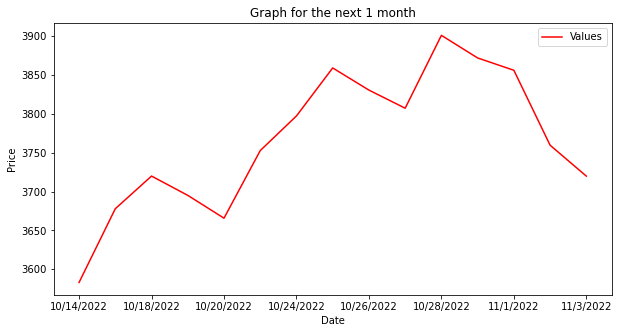

In [20]:
onemonth_df_pred = pd.read_csv("sp500_data_test1m.csv")
onemonth_df_pred.set_index("Date", inplace=True)
buy_price = min(onemonth_df_pred["Values"])
sell_price = max(onemonth_df_pred["Values"])
onemonth_buy = onemonth_df_pred.loc[onemonth_df_pred["Values"] == buy_price]
onemonth_sell = onemonth_df_pred.loc[onemonth_df_pred["Values"] == sell_price]
print("Buy price and date")
print(onemonth_buy)
print("Sell price and date")
print(onemonth_sell)
onemonth_df_pred["Values"].plot(figsize=(10, 5), title="Graph for the next 1 month", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

Buy price and date
            Predictions
Date                   
10/18/2022  2428.738414
Sell price and date
            Predictions
Date                   
10/14/2022  2863.876933


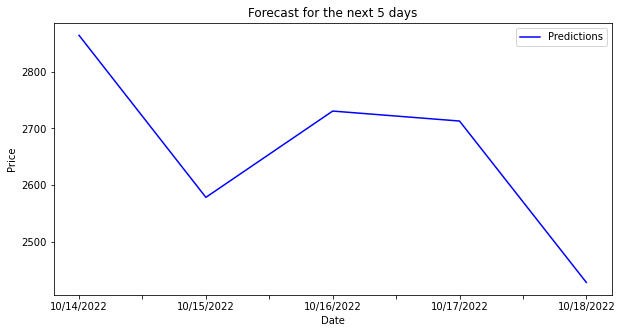

In [22]:
fivedays_df_pred = pd.read_csv("five-days-predictions.csv")
fivedays_df_pred.set_index("Date", inplace=True)
buy_price = min(fivedays_df_pred["Predictions"])
sell_price = max(fivedays_df_pred["Predictions"])
fivedays_buy = fivedays_df_pred.loc[fivedays_df_pred["Predictions"] == buy_price]
fivedays_sell = fivedays_df_pred.loc[fivedays_df_pred["Predictions"] == sell_price]
print("Buy price and date")
print(fivedays_buy)
print("Sell price and date")
print(fivedays_sell)
fivedays_df_pred["Predictions"].plot(figsize=(10, 5), title="Forecast for the next 5 days", color="blue")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()